In [1]:
#Binary Classification
import zipfile
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import glob
from torch.autograd import Variable
from torchvision import models
from torch.nn import Module,  Linear, ReLU, CrossEntropyLoss, Sequential, Conv3d, MaxPool3d, Softmax, BatchNorm3d
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
#walk through directory and list through files
for dirpath, dirnames, filenames in os.walk("/content/drive/My Drive/ADNI_full"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
len(filenames)

There are 4 directories and 0 images in '/content/drive/My Drive/ADNI_full'.
There are 0 directories and 189 images in '/content/drive/My Drive/ADNI_full/AD'.
There are 0 directories and 220 images in '/content/drive/My Drive/ADNI_full/LMCI'.
There are 0 directories and 254 images in '/content/drive/My Drive/ADNI_full/CN'.
There are 0 directories and 0 images in '/content/drive/My Drive/ADNI_full/.ipynb_checkpoints'.


0

#Loading AD Samples

In [5]:
AD = glob.glob(r'/content/drive/MyDrive/ADNI_full/AD/*.nii.gz')
ADFiles = AD
ADtotalfiles = len(ADFiles)
print('Found ', str(ADtotalfiles), ' nifti files')

x_range_from = 10; x_range_to = 110
y_range_from = 40; y_range_to = 95
z_range_from = 5; z_range_to = 105
ADimages = np.zeros((ADtotalfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), 
                  dtype=np.float32) 
print(ADimages.shape)

# Actually load nifti files into array
for i in range(ADtotalfiles):   
    if (i % 10 == 0):
        print('Loading file %d of %d' % (i+1, ADtotalfiles))
    AD_img = nib.load(ADFiles[i])
    AD_img = AD_img.get_fdata()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
    AD_img = np.transpose(AD_img, (2, 0, 1)) 
    AD_img = np.flip(AD_img) # flip all positions
    ADimages[i, :,:,:, 0] = np.nan_to_num(AD_img)
print('Successfully loaded files')
print('Image array size: ', ADimages.shape)

#y_label for AD
label_AD=np.full(len(ADimages),1)
print('LabelAD size: ', label_AD.shape)

Found  189  nifti files
(189, 100, 100, 55, 1)
Loading file 1 of 189
Loading file 11 of 189
Loading file 21 of 189
Loading file 31 of 189
Loading file 41 of 189
Loading file 51 of 189
Loading file 61 of 189
Loading file 71 of 189
Loading file 81 of 189
Loading file 91 of 189
Loading file 101 of 189
Loading file 111 of 189
Loading file 121 of 189
Loading file 131 of 189
Loading file 141 of 189
Loading file 151 of 189
Loading file 161 of 189
Loading file 171 of 189
Loading file 181 of 189
Successfully loaded files
Image array size:  (189, 100, 100, 55, 1)
LabelAD size:  (189,)


#Loading CN samples

In [6]:
CN = glob.glob(r'/content/drive/MyDrive/ADNI_full/CN/*.nii.gz')
CNFiles = CN
CNtotalfiles = len(CNFiles)
print('Found ', str(CNtotalfiles), ' nifti files')


x_range_from = 10; x_range_to = 110
y_range_from = 40; y_range_to = 95
z_range_from = 5; z_range_to = 105
CNimages = np.zeros((CNtotalfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), 
                  dtype=np.float32) 
print(CNimages.shape)

# Actually load nifti files into array
for i in range(CNtotalfiles):  
    if (i % 10 == 0):
        print('Loading file %d of %d' % (i+1, CNtotalfiles))
    CN_img = nib.load(CNFiles[i])
    CN_img = CN_img.get_fdata()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
    CN_img = np.transpose(CN_img, (2, 0, 1)) 
    CN_img = np.flip(CN_img)
    #print(img.shape)
    CNimages[i, :,:,:, 0] = np.nan_to_num(CN_img)
print('Successfully loaded files')
print('Image array size: ', CNimages.shape)
#y_label for CN
label_CN=np.full(len(CNimages),0)
print('LabelCN size: ', label_CN.shape)



Found  254  nifti files
(254, 100, 100, 55, 1)
Loading file 1 of 254
Loading file 11 of 254
Loading file 21 of 254
Loading file 31 of 254
Loading file 41 of 254
Loading file 51 of 254
Loading file 61 of 254
Loading file 71 of 254
Loading file 81 of 254
Loading file 91 of 254
Loading file 101 of 254
Loading file 111 of 254
Loading file 121 of 254
Loading file 131 of 254
Loading file 141 of 254
Loading file 151 of 254
Loading file 161 of 254
Loading file 171 of 254
Loading file 181 of 254
Loading file 191 of 254
Loading file 201 of 254
Loading file 211 of 254
Loading file 221 of 254
Loading file 231 of 254
Loading file 241 of 254
Loading file 251 of 254
Successfully loaded files
Image array size:  (254, 100, 100, 55, 1)
LabelCN size:  (254,)


In [ ]:
#Concatenation of training data
X=np.concatenate((CNimages, ADimages), axis=0)
print('x data of train size: ', X.shape)
y=np.concatenate((labelCNN,labelADD), axis=0)
print('y data in  of train size: ', y.shape)

x data of train size:  (443, 100, 100, 55, 1)
y data in  of train size:  (443,)


In [ ]:
X.shape, y.shape

((443, 100, 100, 55, 1), (443,))

In [ ]:
X = torch.from_numpy(X)
X.shape, X.dtype

(torch.Size([443, 100, 100, 55, 1]), torch.float32)

In [ ]:
X=X.reshape(443,1,100,100,55)

X.shape, y.shape

(torch.Size([443, 1, 100, 100, 55]), (443,))

In [ ]:
X=X.expand(-1,3,-1,-1,-1)
X.shape

torch.Size([443, 3, 100, 100, 55])

In [ ]:
y = torch.from_numpy(y)
y.shape, y.dtype

(torch.Size([443]), torch.int64)

In [ ]:
from sklearn.model_selection import train_test_split
#batch_size=32
X_train,X_test_data, y_train,y_test_data =train_test_split(X,y, test_size=0.2,  random_state=42)
X_val,X_test,y_val,y_test= train_test_split(X_test_data,y_test_data, test_size=0.5,random_state=42)
#X_train, X_test, y_train, y_test,X_val,y_val = X_train.cuda(), X_test.cuda(), y_train.cuda(), y_test.cuda(),X_val.cuda(), y_val.cuda()

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape),(X_val.shape,y_val.shape),(X_train.dtype, y_train.dtype)

((torch.Size([354, 3, 100, 100, 55]), torch.Size([354])),
 (torch.Size([45, 3, 100, 100, 55]), torch.Size([45])),
 (torch.Size([44, 3, 100, 100, 55]), torch.Size([44])),
 (torch.float32, torch.int64))

In [ ]:
from torch.utils.data import DataLoader,TensorDataset
BATCH_SIZE = 10
dataset = TensorDataset(X_train, y_train)
dataset1= TensorDataset(X_val, y_val)
dataset2 = TensorDataset(X_test, y_test)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
Validation_dataloader= DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader= DataLoader(dataset2,batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
Binary_AD_finetune = models.video.r3d_18(pretrained=True, progress=False)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


In [ ]:
Binary_AD_finetune=Binary_AD_finetune.to(device)

In [ ]:
print(Binary_AD_finetune)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [ ]:
Binary_AD_finetune.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Sequential(
      (0): Conv3DSimple(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv3DSimple(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv3d(256, 512, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Sequential(
      (0): Conv3DSimple(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
for param in Binary_AD_finetune.layer4.parameters():
    param.requires_grad = False

In [ ]:
Binary_AD_finetune.fc =  nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 2),
            )
for param in Binary_AD_finetune.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Binary_AD_finetune.fc.parameters(), lr=0.0001) #Learning rate must be low due to finetunning

In [ ]:
summary(Binary_AD_finetune, (3, 100, 100,55))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 64, 100, 50, 28]          28,224
       BatchNorm3d-2      [-1, 64, 100, 50, 28]             128
              ReLU-3      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-4      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-5      [-1, 64, 100, 50, 28]             128
              ReLU-6      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-7      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-8      [-1, 64, 100, 50, 28]             128
              ReLU-9      [-1, 64, 100, 50, 28]               0
       BasicBlock-10      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-11      [-1, 64, 100, 50, 28]         110,592
      BatchNorm3d-12      [-1, 64, 100, 50, 28]             128
             ReLU-13      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-14      [-1, 64, 100,

In [ ]:

import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_dataloader):
        b+=1
        
        # Apply the model
        y_pred = Binary_AD_finetune(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/354]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(Validation_dataloader):

            # Apply the model
            outputs = Binary_AD_finetune(X_val)

            # Tally the number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()
            
    loss = criterion(outputs, y_val)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch:   10 [   100/354]  loss: 0.56505740  accuracy:  59.000%
epoch:  0  batch:   20 [   200/354]  loss: 0.63094473  accuracy:  56.500%
epoch:  0  batch:   30 [   300/354]  loss: 0.60252118  accuracy:  58.333%
epoch:  1  batch:   10 [   100/354]  loss: 0.68124455  accuracy:  64.000%
epoch:  1  batch:   20 [   200/354]  loss: 0.67226303  accuracy:  65.000%
epoch:  1  batch:   30 [   300/354]  loss: 0.65848178  accuracy:  64.000%
epoch:  2  batch:   10 [   100/354]  loss: 0.57790798  accuracy:  64.000%
epoch:  2  batch:   20 [   200/354]  loss: 0.59458852  accuracy:  62.000%
epoch:  2  batch:   30 [   300/354]  loss: 0.80016148  accuracy:  61.000%
epoch:  3  batch:   10 [   100/354]  loss: 0.58993882  accuracy:  60.000%
epoch:  3  batch:   20 [   200/354]  loss: 0.74020994  accuracy:  59.500%
epoch:  3  batch:   30 [   300/354]  loss: 0.51250517  accuracy:  63.333%
epoch:  4  batch:   10 [   100/354]  loss: 0.64538217  accuracy:  72.000%
epoch:  4  batch:   20 [   200/354]  l

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

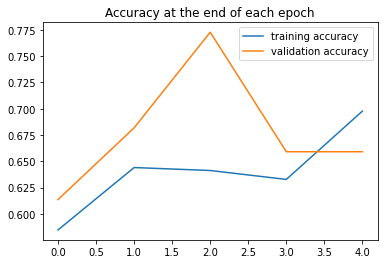

In [ ]:
plt.plot([t/354 for t in train_correct], label='training accuracy')
plt.plot([t/44 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

#Evaluation Model

In [ ]:
torch.manual_seed(62)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_dataloader:
        y_val1 = Binary_AD_finetune(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val1,1)[1]
        correct += (predicted == y_test).sum()
print(f'Testing  accuracy: {correct.item()}/{len(dataset2)} = {correct.item()*100/(len(dataset2)):7.3f}%')

Testing  accuracy: 26/45 =  57.778%


In [ ]:

torch.manual_seed(63)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = Binary_AD_finetune(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 45 test images: {100 * correct // total} %')

Accuracy of the network on the 45 test images: 64 %


No handles with labels found to put in legend.


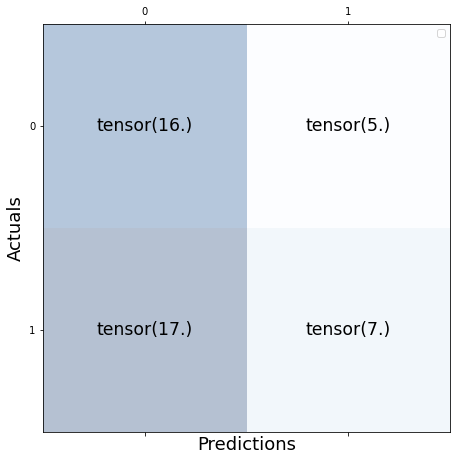

tensor([0.7619, 0.2917])


In [ ]:
torch.manual_seed(64)
nb_classes = 2
from sklearn.metrics import confusion_matrix
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = Binary_AD_finetune(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
  for j in range(confusion_matrix.shape[1]):
    ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.legend()
plt.show();
print(confusion_matrix.diag()/confusion_matrix.sum(1))
#print(confusion_matrix)

In [ ]:
torch.manual_seed(65)
# prepare to count predictions for each class
classes= ['CN','AD']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for X_test, y_test in test_dataloader:
        outputs = Binary_AD_finetune(X_test)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(y_test, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class CN    is: 81.0 %
Accuracy for class AD    is: 37.5 %


In [ ]:
torch.manual_seed(66)
y_pred_list = []
labels_list = []
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        batch_size = images.shape[0]
        # calculate outputs by running images through the network
        outputs = Binary_AD_finetune(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.detach().numpy()
        labels=labels.detach().numpy()
        for i in range(batch_size):
          y_pred_list.append(predicted[i])
          labels_list.append(labels[i])

print(f'Accuracy of the network on the 45 test images: {100 * correct // total} %')
matthews_corrcoef(y_pred_list, labels_list) 


Accuracy of the network on the 45 test images: 55 %


0.1475329266648508

In [ ]:
len(y_pred_list)

45

In [ ]:
len(labels_list)

45

In [ ]:
acc = accuracy_score(y_pred_list,labels_list)
print(acc)

0.5555555555555556


In [ ]:
balanced_accuracy_score(y_pred_list,labels_list)


0.5794930875576036

In [ ]:
filepath='Binary_classification_AD.pt'
torch.save(Binary_AD_finetune.state_dict(), filepath)